In [1]:
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Constrained_Delaunay_triangulation_2

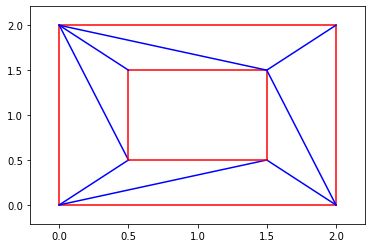

In [5]:
class FaceInfo2(object):
    def __init__(self):
        self.nesting_level = -1

    def in_domain(self):
        return (self.nesting_level % 2) != 1


def mark_domains(ct, start_face, index, edge_border, face_info):
    if face_info[start_face].nesting_level != -1:
        return
    queue = [start_face]
    while queue != []:
        fh = queue[0]     # queue.front
        queue = queue[1:]  # queue.pop_front
        if face_info[fh].nesting_level == -1:
            face_info[fh].nesting_level = index
            for i in range(3):
                e = (fh, i)
                n = fh.neighbor(i)
                if face_info[n].nesting_level == -1:
                    if ct.is_constrained(e):
                        edge_border.append(e)
                    else:
                        queue.append(n)


def mark_domain(cdt):
    """Find a mapping that can be tested to see if a face is in a domain
    Explore the set of facets connected with non constrained edges,
    and attribute to each such set a nesting level.
    We start from the facets incident to the infinite vertex, with a
    nesting level of 0. Then we recursively consider the non-explored
    facets incident to constrained edges bounding the former set and
    increase the nesting level by 1.
    Facets in the domain are those with an odd nesting level.
    """
    face_info = {}
    for face in cdt.all_faces():
        face_info[face] = FaceInfo2()
    index = 0
    border = []
    mark_domains(cdt, cdt.infinite_face(), index+1, border, face_info)
    while border != []:
        e = border[0]       # border.front
        border = border[1:]  # border.pop_front
        n = e[0].neighbor(e[1])
        if face_info[n].nesting_level == -1:
            lvl = face_info[e[0]].nesting_level+1
            mark_domains(cdt, n, lvl, border, face_info)
    return face_info


def insert_polygon(cdt, polygon):
    if not polygon:
        return

    handles = [cdt.insert(polypt) for polypt in polygon]
    for i in range(len(polygon)-1):
        cdt.insert_constraint(handles[i], handles[i+1])
    cdt.insert_constraint(handles[-1], handles[0])


if __name__ == "__main__":

    def plot_triangulated_polygon(cdt, face_info):
        # This code is an additional element which recreates the figure
        # presented in the original CGAL example. Given the ease of which
        # a standard plotting library can be installed for python, it
        # makes sense to offer some form of visualisation directly
        try:
            import matplotlib.pyplot as plt
        except Exception:
            print('plotting of triangulation not supported')
            return

        def rescale_plot(ax, scale=1.1):
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xmid = (xmin+xmax)/2.0
            ymid = (ymin+ymax)/2.0
            xran = xmax - xmid
            yran = ymax - ymid
            ax.set_xlim(xmid - xran*scale, xmid + xran*scale)
            ax.set_ylim(ymid - yran*scale, ymid + yran*scale)

        def plot_edge(edge, *args):
            edge_seg = cdt.segment(edge)
            pts = [edge_seg.source(), edge_seg.target()]
            xs = [pts[0].x(), pts[1].x()]
            ys = [pts[0].y(), pts[1].y()]
            plt.plot(xs, ys, *args)

        for edge in cdt.finite_edges():
            if cdt.is_constrained(edge):
                plot_edge(edge, 'r-')
            else:
                if face_info[edge[0]].in_domain():
                    plot_edge(edge, 'b-')
        rescale_plot(plt.gca())
        plt.show()

    def main():
        # Construct two non-intersecting nested polygons
        polygon1 = [
            Point_2(0, 0),
            Point_2(2, 0),
            Point_2(2, 2),
            Point_2(0, 2)
        ]

        polygon2 = [
            Point_2(0.5, 0.5),
            Point_2(1.5, 0.5),
            Point_2(1.5, 1.5),
            Point_2(0.5, 1.5)
        ]

        # Insert the polygons into a constrained triangulation
        cdt = Constrained_Delaunay_triangulation_2()
        insert_polygon(cdt, polygon1)
        insert_polygon(cdt, polygon2)

        # Mark facest that are inside the domain bounded by the polygon
        face_info = mark_domain(cdt)

        plot_triangulated_polygon(cdt, face_info)

    main()